In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import figure_factory as FF
from plotly.offline import iplot
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn import preprocessing,cluster
from scipy.stats import kurtosis,skew,pearsonr
from scipy.cluster.hierarchy import linkage, dendrogram
from collections import Counter

from warnings import simplefilter
simplefilter("ignore")

In [3]:
data = pd.read_csv("E:\Machine Learning\Module 14\K-Means-Clustering\Mall_Customers.csv")
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
print(f'There are {data.isnull().sum().sum()} null values in the dataset.')

There are 0 null values in the dataset.


In [5]:
print(f'There are {data.duplicated().sum()} duplicate rows in the dataset.')

There are 0 duplicate rows in the dataset.


In [6]:
print(f'The dataset has {data.shape[1]} columns and {data.shape[0]} rows.')

The dataset has 5 columns and 200 rows.


In [7]:
data.dtypes

CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

All the columns are numeric, except 'Gender'.

Basic Statistics

This is important to find out whether there are possible outliers and/or anomalous values.

In [8]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


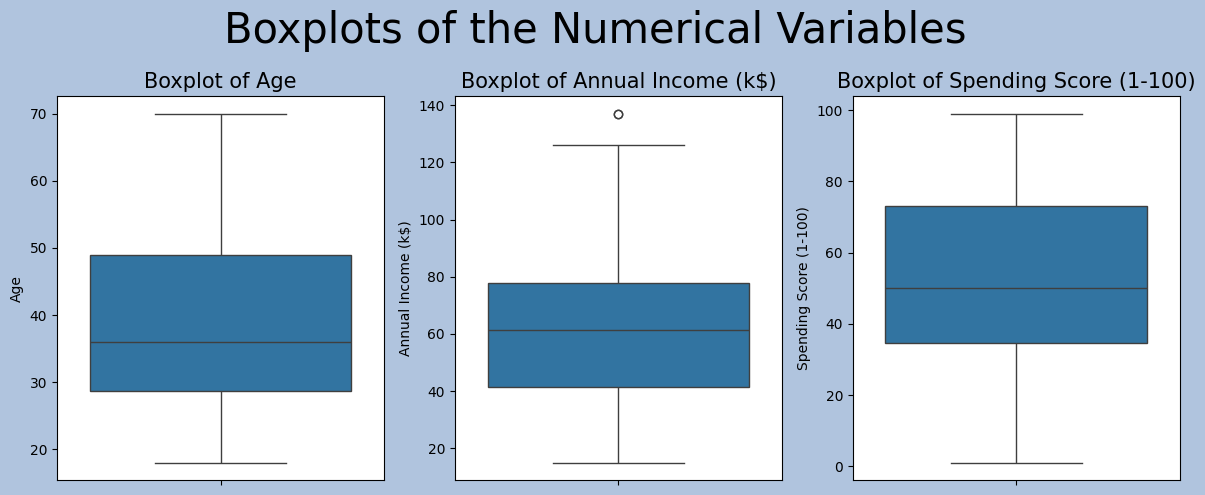

In [9]:
features = ['Age','Annual Income (k$)','Spending Score (1-100)']

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))

ax1 = sns.boxplot(data[features[0]],ax=ax1)
ax1.set_title('Boxplot of '+str(features[0]),fontsize=15)

ax2 = sns.boxplot(data[features[1]],ax=ax2)
ax2.set_title('Boxplot of '+str(features[1]),fontsize=15)

ax3 = sns.boxplot(data[features[2]],ax=ax3)
ax3.set_title('Boxplot of '+str(features[2]),fontsize=15)

fig.suptitle("Boxplots of the Numerical Variables",fontsize=30)    

plt.tight_layout()
fig.set_facecolor('lightsteelblue')

In [10]:
outliers_perc = []

for k,v in data[features].items():
    # Column must be of numeric type (not object)
    if data[k].dtype != 'O':
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        out_tuple = (k,int(perc))
        outliers_perc.append(out_tuple)
        print("Column %s outliers = %.2f%%" % (k,perc))

Column Age outliers = 0.00%
Column Annual Income (k$) outliers = 1.00%
Column Spending Score (1-100) outliers = 0.00%


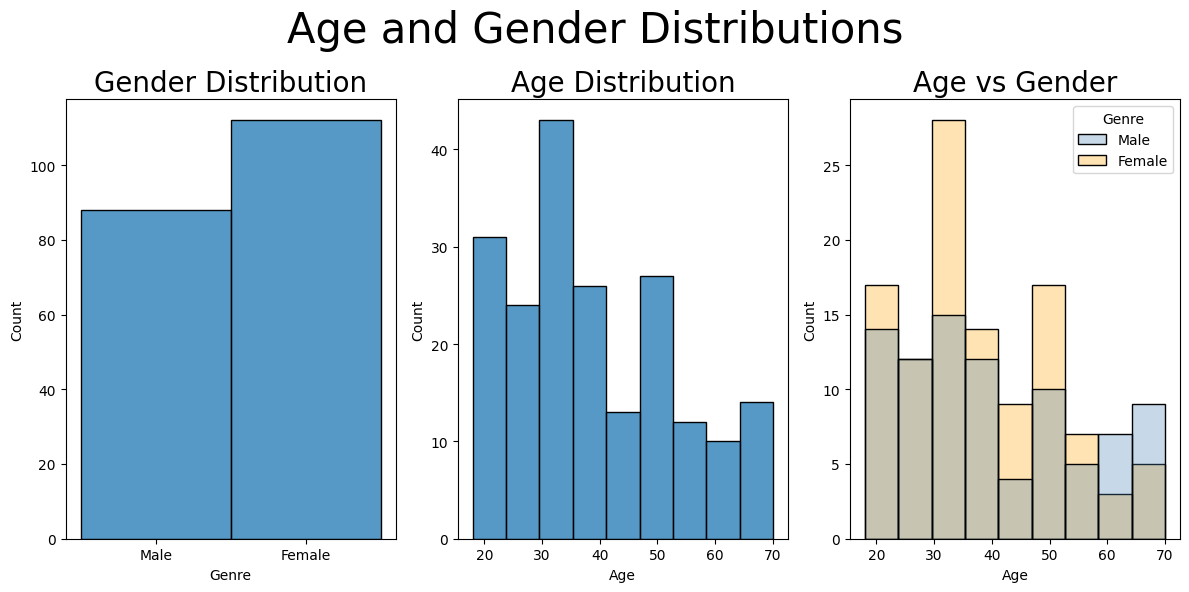

In [14]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(data=data,x='Genre',ax=ax1)
ax1.set_title('Gender Distribution',size=20)

ax2 = sns.histplot(data=data,x='Age',ax=ax2)
ax2.set_title('Age Distribution',size=20)

ax3 = sns.histplot(data=data,x='Age',hue='Genre',palette=['steelblue','orange'],alpha=0.3,ax=ax3)
ax3.set_title('Age vs Gender',size=20)

plt.suptitle('Age and Gender Distributions',size=30)

plt.tight_layout()

In [15]:
print(f"Females: {data['Genre'].value_counts()[0] / len(data) * 100:.0f}% \
      Males: {data['Genre'].value_counts()[1] / len(data) * 100:.0f}%")

Females: 56%       Males: 44%


In [17]:
print(f"Average age = {data['Age'].mean():.0f} +/- {data['Age'].std():.0f}")

print(f"Average age females = {data.loc[data.Genre == 'Female']['Age'].mean():.0f} +/- {data.loc[data.Genre == 'Female']['Age'].std():.0f}")

print(f"Average age males = {data.loc[data.Genre == 'Male']['Age'].mean():.0f} +/- {data.loc[data.Genre == 'Male']['Age'].std():.0f}")

Average age = 39 +/- 14
Average age females = 38 +/- 13
Average age males = 40 +/- 16


In [18]:

age_bins = [18,31,44,57,74]
age_labels = [f"{i}-{i+14}" for i in range(18,74,14)]
data['ageGroups'] = pd.cut(data['Age'],bins=age_bins,labels=age_labels,right=False)


data['ageGroups'].value_counts()

ageGroups
32-46    67
18-32    62
46-60    43
60-74    28
Name: count, dtype: int64

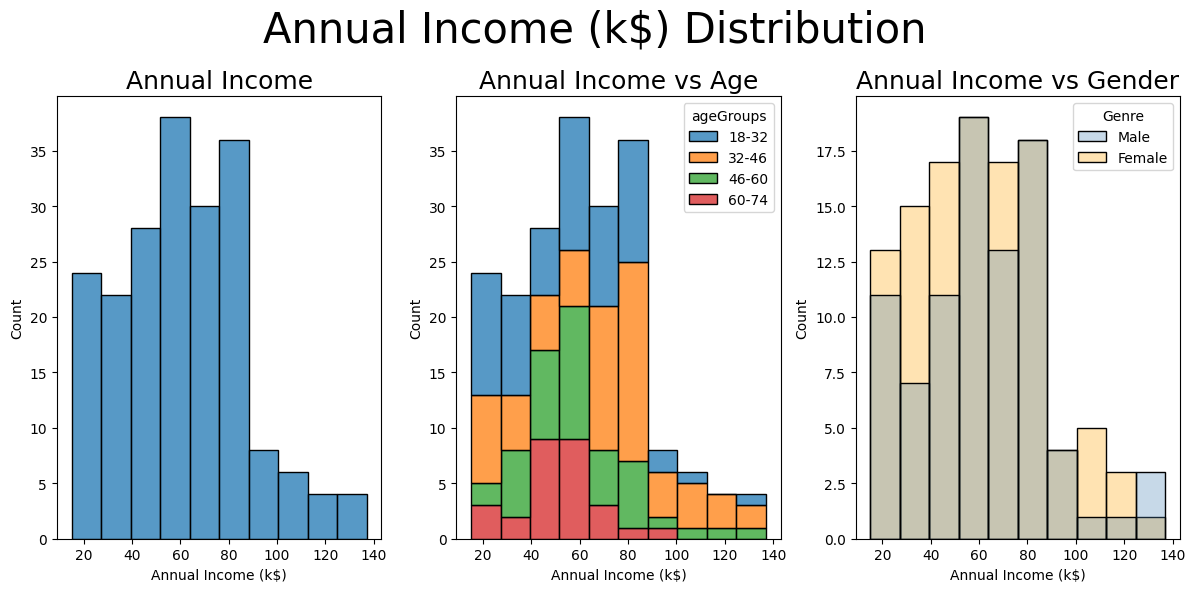

In [21]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(data=data,x='Annual Income (k$)',ax=ax1)
ax1.set_title('Annual Income',size=18)

ax2 = sns.histplot(data=data,x='Annual Income (k$)',hue='ageGroups',multiple="stack",ax=ax2)
ax2.set_title('Annual Income vs Age',size=18)

ax3 = sns.histplot(data=data,x='Annual Income (k$)',hue='Genre',palette=['steelblue','orange'],alpha=0.3,ax=ax3)
ax3.set_title('Annual Income vs Gender',size=18)

plt.suptitle('Annual Income (k$) Distribution',size=30)

plt.tight_layout()

In [22]:
data.groupby('ageGroups')['Annual Income (k$)'].mean()

ageGroups
18-32    55.209677
32-46    69.208955
46-60    59.860465
60-74    52.785714
Name: Annual Income (k$), dtype: float64

<Figure size 1200x600 with 0 Axes>

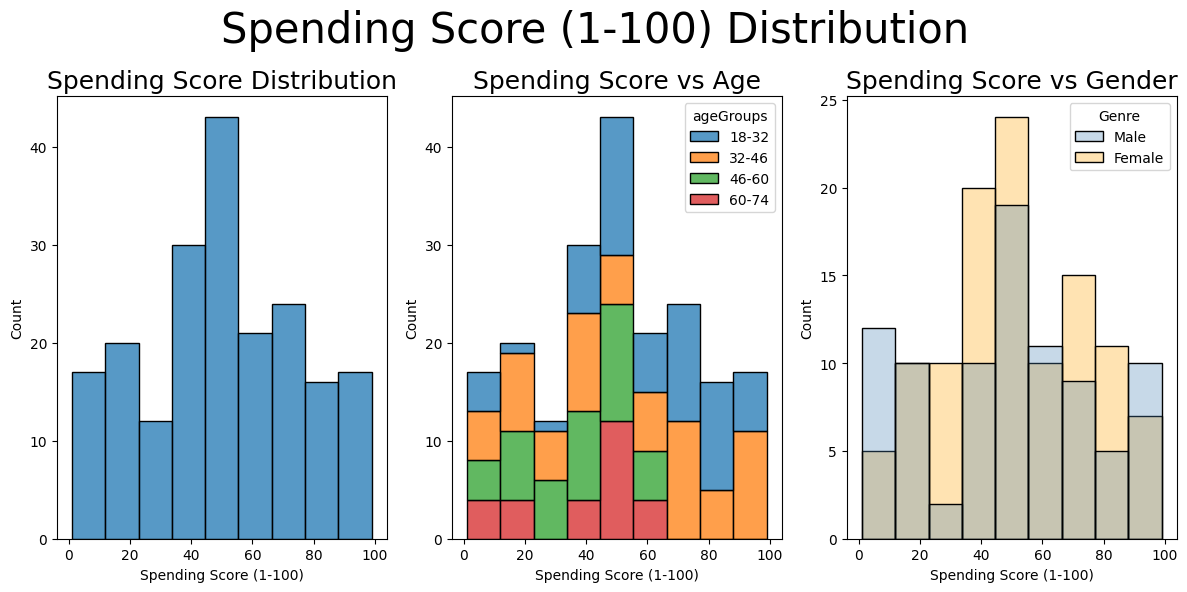

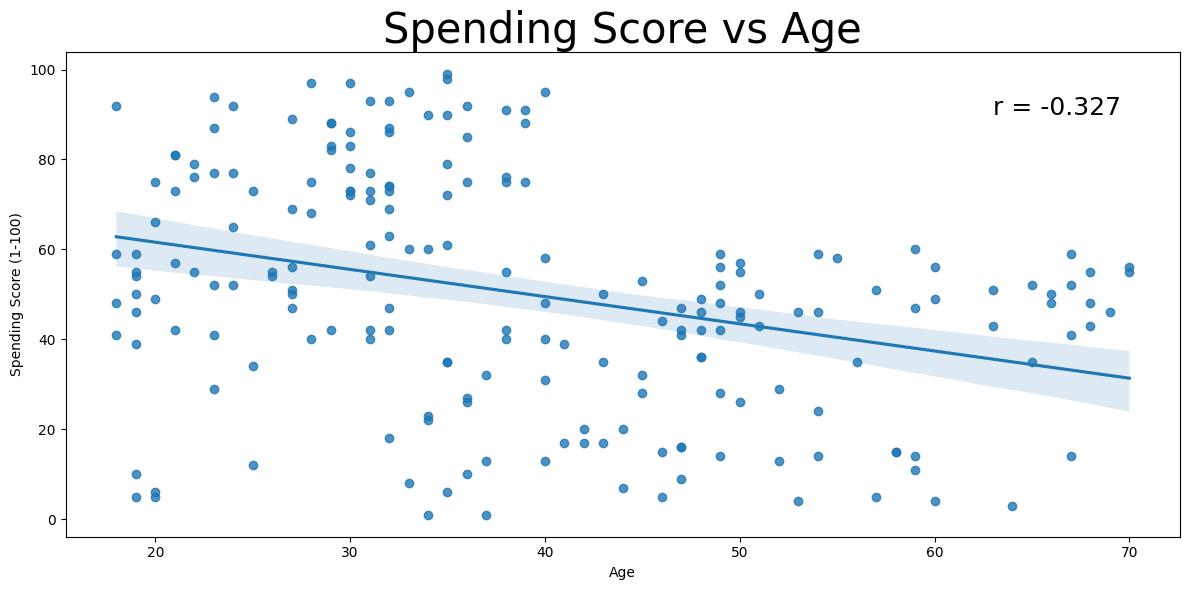

In [25]:
### Correlation: Spending Score vs Age ###

# Convert dataframe into series
list1 = data['Age']
list2 = data['Spending Score (1-100)']

# Apply the pearsonr()
corr, _ = pearsonr(list1,list2)


fig = plt.figure(figsize=(12,6))
(topfig,bottomfig) = fig.subfigures(2,1)

topfig.subplots_adjust(left=.1,right=.9,wspace=.1,hspace=.1)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(data=data,x='Spending Score (1-100)',ax=ax1)
ax1.set_title('Spending Score Distribution',size=18)

ax2 = sns.histplot(data=data,x='Spending Score (1-100)',hue='ageGroups',multiple="stack",ax=ax2)
ax2.set_title('Spending Score vs Age',size=18)

ax3 = sns.histplot(data=data,x='Spending Score (1-100)',hue='Genre',palette=['steelblue','orange'],alpha=0.3,ax=ax3)
ax3.set_title('Spending Score vs Gender',size=18)

plt.suptitle('Spending Score (1-100) Distribution',size=30)

plt.tight_layout()

bottomfig.subplots_adjust(left=.1,right=.9,wspace=.1,hspace=.1)

ax = plt.figure(figsize=(12,6))

ax = sns.regplot(data=data,x='Age',y='Spending Score (1-100)')
ax.set_title('Spending Score vs Age',size=30)
ax.text(63,90,f"r = {corr:.3f}",size=18)

plt.tight_layout()

In [26]:
data.groupby('ageGroups')['Spending Score (1-100)'].mean()

ageGroups
18-32    61.032258
32-46    54.402985
46-60    35.651163
60-74    38.500000
Name: Spending Score (1-100), dtype: float64

In [27]:
data.groupby('Genre')['Spending Score (1-100)'].mean()

Genre
Female    51.526786
Male      48.511364
Name: Spending Score (1-100), dtype: float64

KMeans Clustering

In [28]:
data2 = data.drop(['CustomerID'],axis=1)

data2.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),ageGroups
0,Male,19,15,39,18-32
1,Male,21,15,81,18-32
2,Female,20,16,6,18-32
3,Female,23,16,77,18-32
4,Female,31,17,40,32-46


Then, I am encoding the 'Gender' variable.

In [31]:
encoder = LabelEncoder()

data2['Genre'] = encoder.fit_transform(data2['Genre'])

data2.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),ageGroups
0,1,19,15,39,18-32
1,1,21,15,81,18-32
2,0,20,16,6,18-32
3,0,23,16,77,18-32
4,0,31,17,40,32-46


standardizing the numerical features.

In [32]:
#data2_sc = data2.drop('ageGroups',axis=1)
data2_sc = data2.drop(['ageGroups','Genre'],axis=1)

scaler = StandardScaler()

scaled_columns = data2_sc.columns

data2_sc[scaled_columns] = scaler.fit_transform(data2_sc[scaled_columns])

data2_sc.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


'Best' Number of Clusters

In [33]:
# Create an empty list to hold many inertia values
inertia_values = []

range_clusters = range(2,16)

# Create 2 - 15 clusters, and add the inertia scores to the list
for k in range_clusters:
    kmeans = KMeans(n_clusters=k,n_init=10,random_state=42)
    kmeans.fit(data2_sc)
    inertia_values.append(kmeans.inertia_)

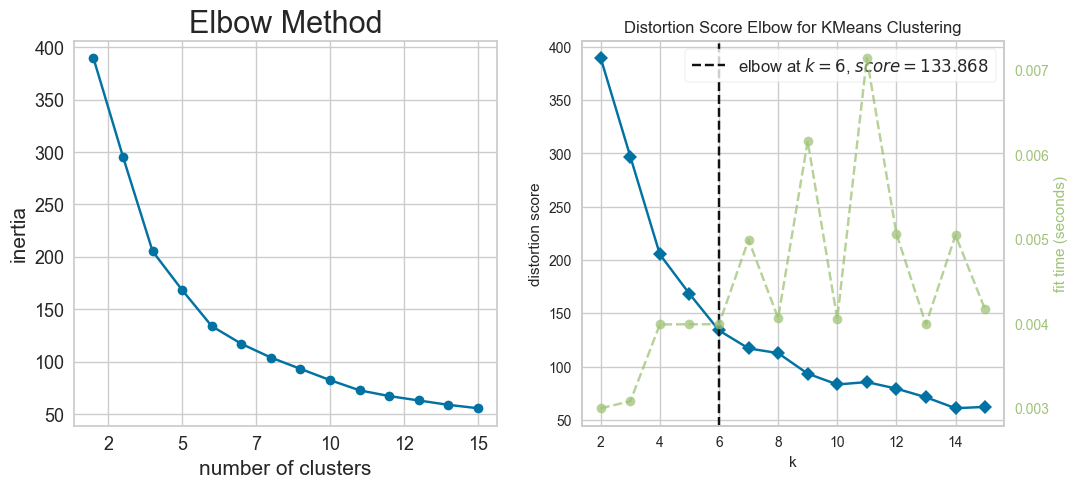

<Figure size 800x550 with 0 Axes>

In [35]:
from yellowbrick.cluster import KElbowVisualizer

features = data2_sc.columns

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))

# First Plot
ax1.plot(range_clusters,inertia_values,marker='o',linestyle='-')
ax1.xaxis.set_tick_params(labelsize=13)
ax1.set_xticklabels(ax1.get_xticks().astype(int))
ax1.yaxis.set_tick_params(labelsize=13)
ax1.set_xlabel("number of clusters",fontsize=15)
ax1.set_ylabel('inertia',fontsize=15)
ax1.set_title("Elbow Method",fontsize=22)

# Second Plot
Elbow_M = KElbowVisualizer(KMeans(),k=15)
Elbow_M.fit(data2_sc[features])
ax2 = Elbow_M.show()

plt.tight_layout() 

According to the elbow method, k = 6 is supposed to be the 'best' number of clusters.

Let's have a look also at the Davies Bouldin score.

In [36]:
davies_bouldin_scores = []

for i in range_clusters:
    kmeans = KMeans(n_clusters=i,random_state=42)
    labels = kmeans.fit_predict(data2_sc)
    score = davies_bouldin_score(data2_sc,labels)
    davies_bouldin_scores.append(score)

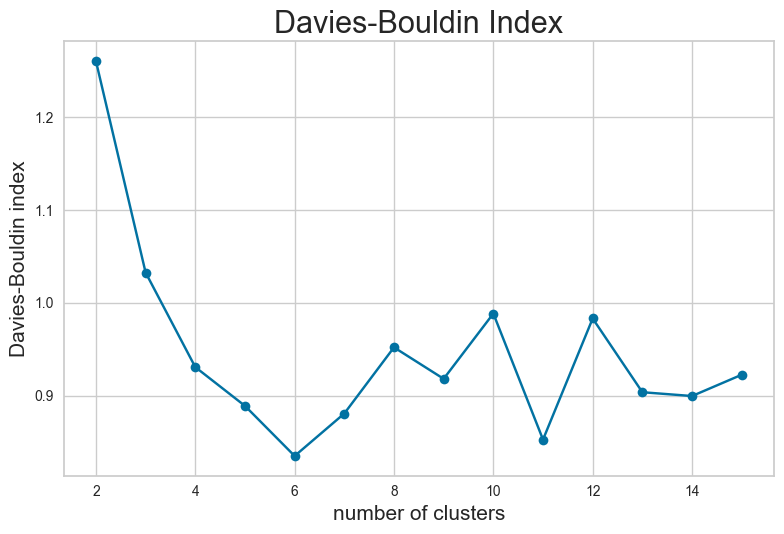

In [37]:
plt.plot(range_clusters,davies_bouldin_scores,marker='o')
plt.xlabel("number of clusters",fontsize=15)
plt.ylabel('Davies-Bouldin index',fontsize=15)
plt.title("Davies-Bouldin Index",fontsize=22)

plt.tight_layout()
plt.show()

The Davies Bouldin score analysis would suggest to consider a similar number of clusters (k = 6), or maybe k = 10.

Finally, let's have a look at the silhouette score.

In [38]:
silhouette_scores = []

for i in range_clusters:
    kmeans = KMeans(n_clusters=i,random_state=42)
    labels = kmeans.fit_predict(data2_sc) 
    score = silhouette_score(data2_sc,labels)
    silhouette_scores.append(score)

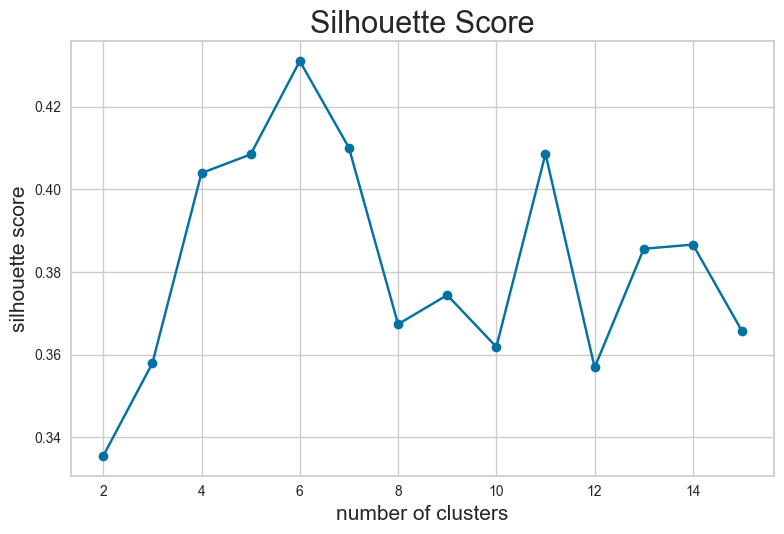

In [39]:
plt.plot(range_clusters,silhouette_scores,marker='o')
plt.xlabel("number of clusters",fontsize=15)
plt.ylabel('silhouette score',fontsize=15)
plt.title("Silhouette Score",fontsize=22)

plt.tight_layout()
plt.show()


According to the silhouette score analysis, k = 6 is a 'good' number of clusters. Also values of k of 9 and 10 are acceptable.

Tune the KMeans Model and Results
In order to decide what is the 'best' value of k, I will agglomerate clusters with k between 3 and 6 and then have a look at the average values 
of the variables in them and also at their spatial distribution. Given that I do not have so many points (they are 200),
I prefer to avoid the use of higher values of k.

In [40]:
def plot_clusters(k,data2,LABELS):

    # Initiating KMeans. n_clusters = k
    km = KMeans(n_clusters=k,n_init=10,random_state=42)

    # Fit model and predict clusters
    yhat = km.fit_predict(data2[LABELS])
    data2[f"{k}_clusters_2D"] = yhat

    # Adding the Clusters feature to the dataframe before encoding and scaling
    data[f"{k}_clusters_2D"] = yhat

    # Initiating PCA to reduce dimentions to 2
    pca = PCA(n_components=2,random_state=42)

    pca.fit(data2[LABELS]) 
    data_sc_2D = pd.DataFrame(pca.transform(data2[LABELS]),columns=(["col1","col2"]))
    data_sc_2D["clusters_2D"] = yhat

    cluster_count = data_sc_2D.groupby("clusters_2D")["clusters_2D"].count().reset_index(name='count').sort_values(by='count',ascending=False)

    print(cluster_count)

    ### Figures ###
    bigfig = plt.figure(figsize=(12,6))

    (top,bottom) = bigfig.subfigures(2,1)

    ### Top figure ###
    top.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)

    k_cluster_data = pd.DataFrame(km.cluster_centers_,columns=LABELS)

    ax = plt.figure(figsize=(12,6))
    
    ax = sns.heatmap(data=k_cluster_data,cmap='RdBu',annot=True)
    ax.set_title('Cluster Centers',fontsize=15)

    plt.suptitle(f'{k} Clusters Case',size=30)

    plt.tight_layout()

    ### Bottom figure ###
    bottom.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)
    fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

    ax1 = sns.barplot(x='clusters_2D',y='count',data=cluster_count,palette='Spectral',ax=ax1)
    ax1.set_xlabel("cluster number",fontsize=15)
    ax1.set_ylabel('count',fontsize=15)
    ax1.set_title(f"Numerical Distribution of the Clusters",fontsize=15)

    ax2 = sns.scatterplot(x="col1",y="col2",data=data_sc_2D,hue="clusters_2D",palette='Spectral',ax=ax2)
    ax2.set_title("2D Representation of the Clusters",fontsize=15)
    legend_handles,_ = ax2.get_legend_handles_labels()

    plt.tight_layout()

Below, I am plotting the cluster distribution for several values of k.

k = 3 Case

I will start with the k = 3 case.

   clusters_2D  count
2            2     91
0            0     68
1            1     41


<Figure size 1200x600 with 0 Axes>

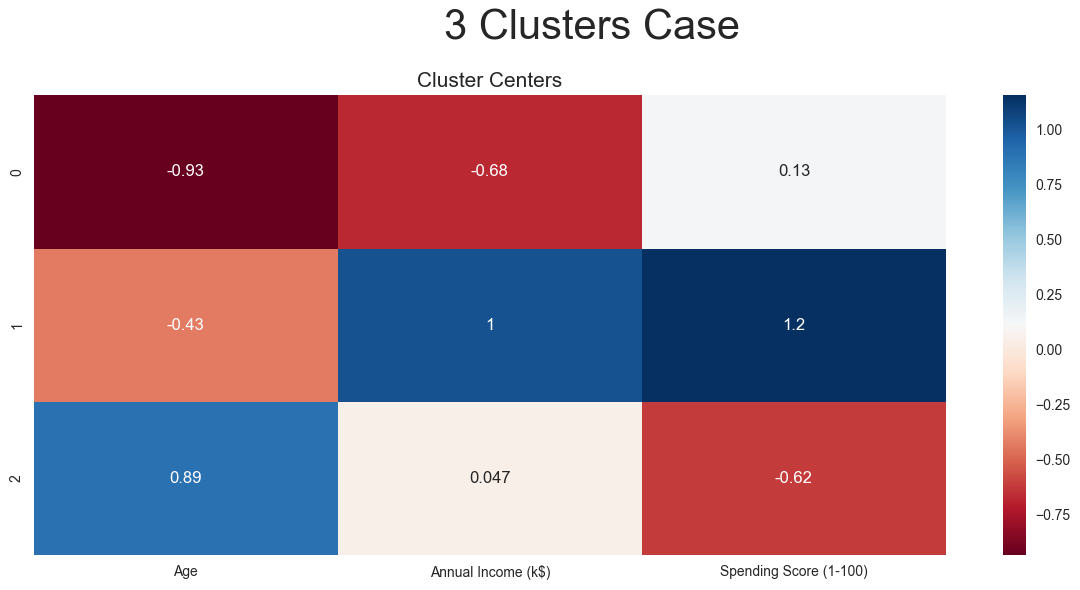

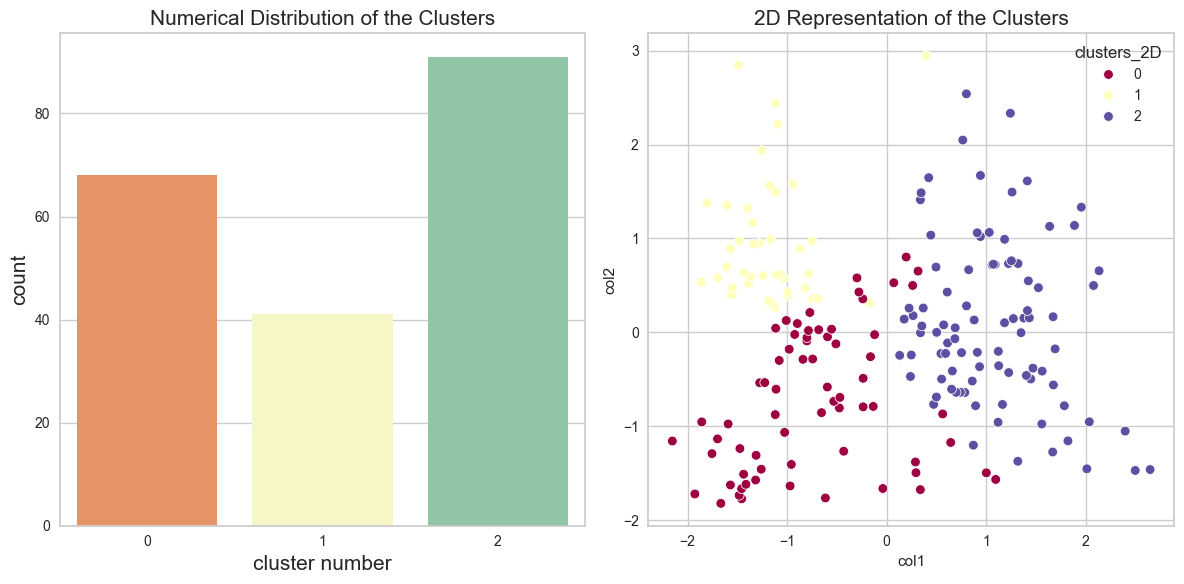

In [41]:
LABELS2 = ['Gender','Age','Annual Income (k$)','Spending Score (1-100)']
LABELS2 = ['Age','Annual Income (k$)','Spending Score (1-100)']

plot_clusters(3,data2_sc,LABELS2)

These three clusters can be interpreted as:

Cluster 0: Youngsters with low income and average spending score.
Cluster 1: Young people (around 30-35-40 y.o.) with high income and high spending score.
Cluster 2: Old people with average income and low spending score.
k = 4 Case

   clusters_2D  count
0            0     65
2            2     57
1            1     40
3            3     38


<Figure size 1200x600 with 0 Axes>

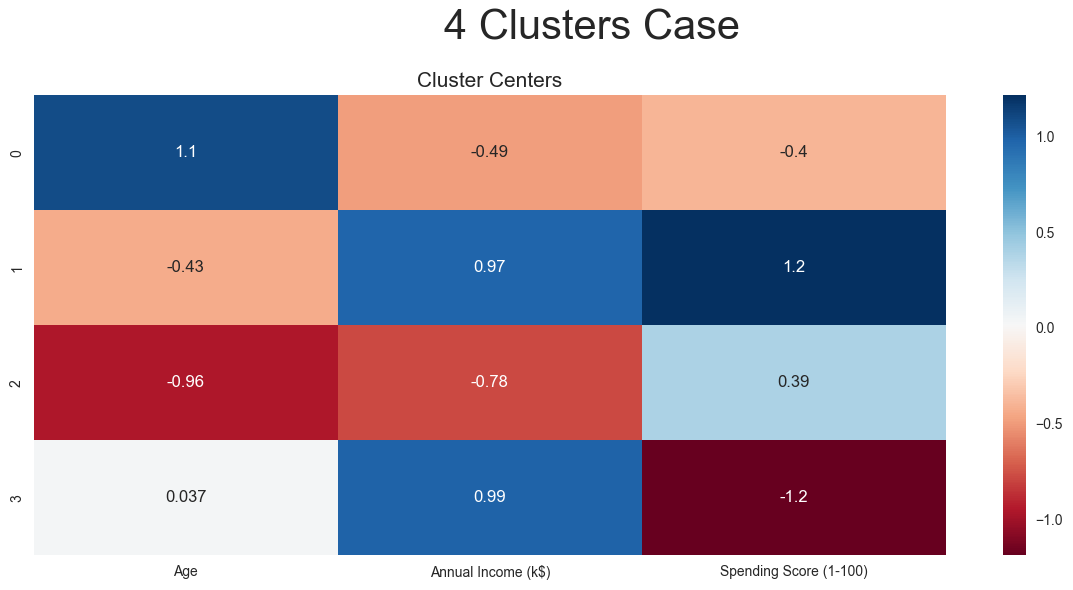

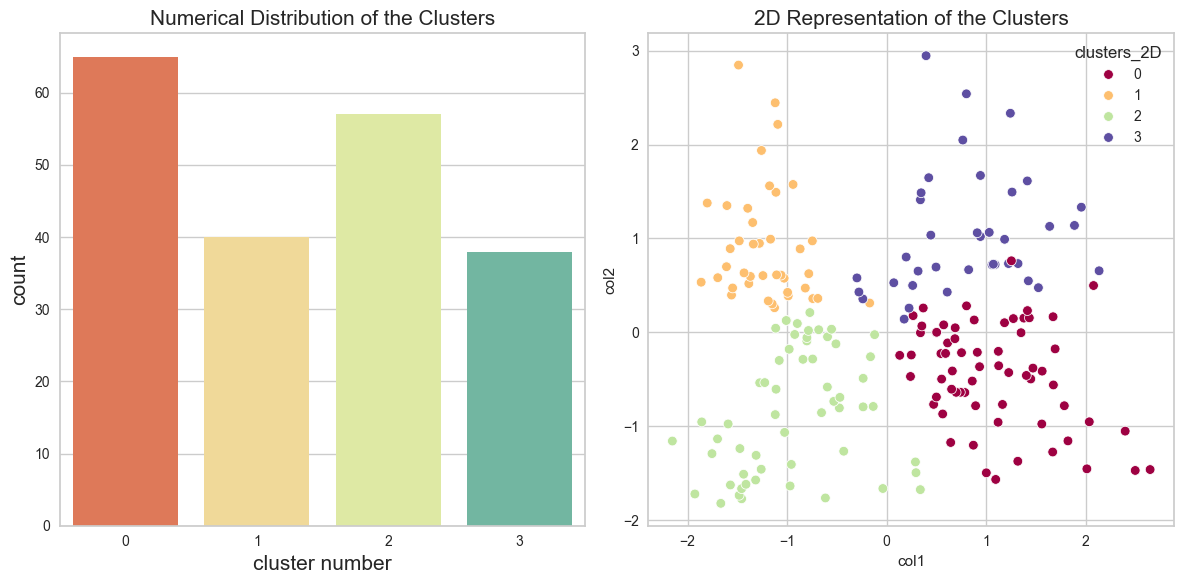

In [42]:
plot_clusters(4,data2_sc,LABELS2)

These four clusters can be interpreted as:

Cluster 0: 35-45 y.o. people with high income and very low spending score.
Cluster 1: 30-35 y.o. people with high income and very high spending score.
Cluster 2: Youngsters with low income and medium-high spending score.
Cluster 3: Old people with medium-low income and medium-low spending score.
k = 5 Case

   clusters_2D  count
1            1     54
4            4     47
2            2     40
3            3     39
0            0     20


<Figure size 1200x600 with 0 Axes>

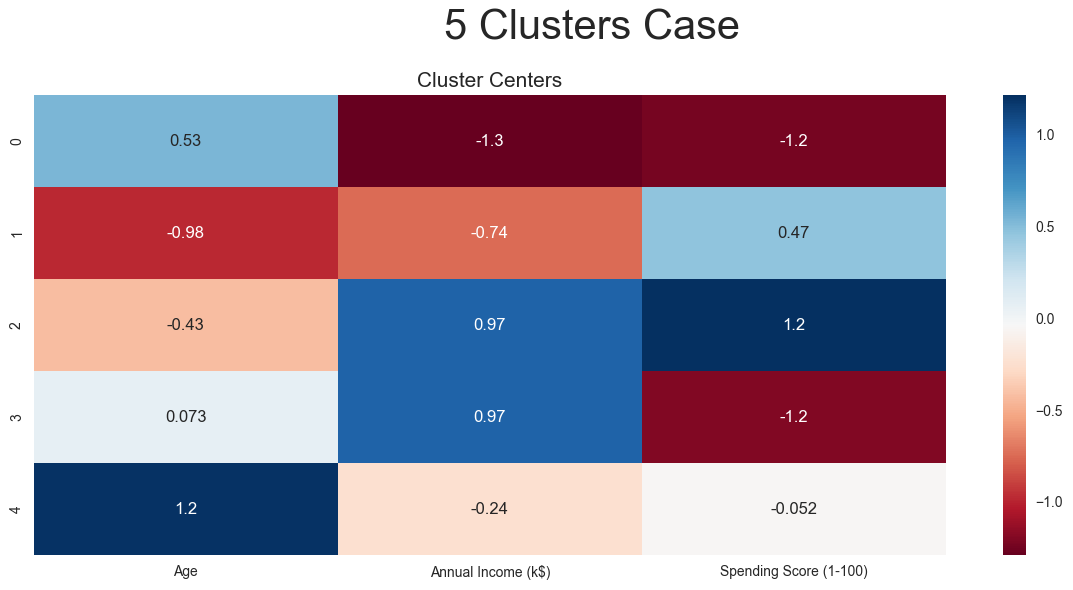

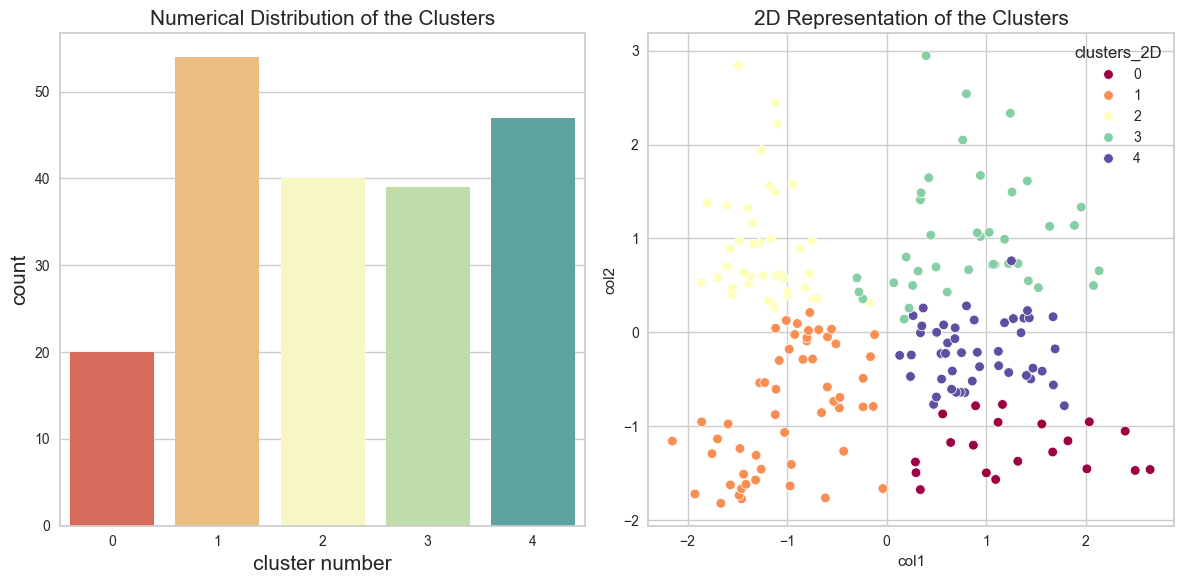

In [43]:
plot_clusters(5,data2_sc,LABELS2)

These five clusters can be interpreted as:

Cluster 0: Old people with average income and average spending score.
Cluster 1: 30 y.o. people with high income and very high spending score.
Cluster 2: Youngsters with low income and medium-high spending score.
Cluster 3: Around 50-60 y.o. people with very low income and very low spending score.
Cluster 4: Around 40 y.o. people with high income and very low spending score.
k = 6 Case

   clusters_2D  count
0            0     45
1            1     39
3            3     39
2            2     33
4            4     23
5            5     21


<Figure size 1200x600 with 0 Axes>

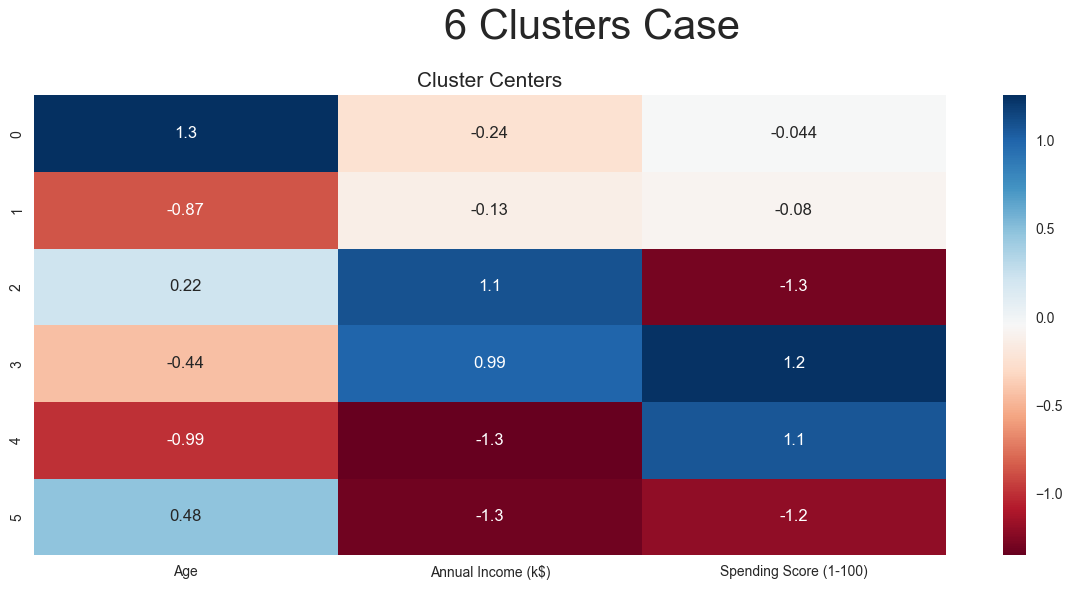

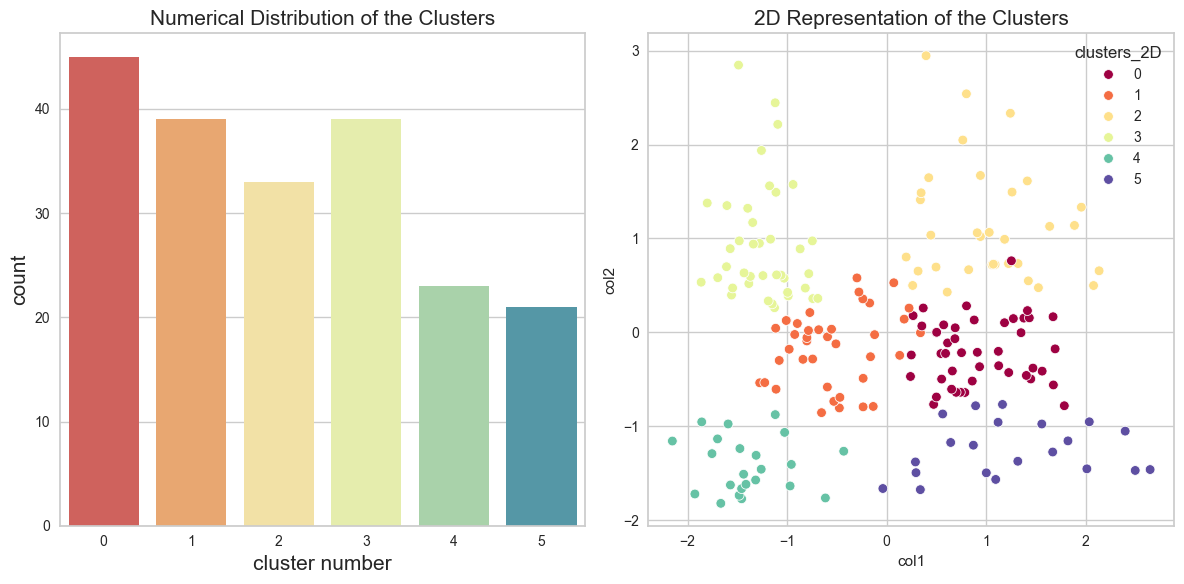

In [44]:
plot_clusters(6,data2_sc,LABELS2)